In [23]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tdt
import trompy as tp

import dill

In [ ]:
DATAFOLDER = Path("..\\data")
df = pd.read_excel(DATAFOLDER / "experiment_info_gsheet.xlsx", sheet_name="Sheet1")

In [24]:
# this function should get snips from the tank
# should add pre, post and other functions
def get_snips(tank):
    # preprocess streams
    
    data = tdt.read_block(tank)
    blue = data.streams["x65A"].data
    uv = data.streams["x05A"].data
    fs = data.streams["x05A"].fs
    
    filtered_sig = tp.processdata(blue, uv, fs=fs)
    
    # get epochs
    sol = data.epocs.Sper.onset
    
    #make snips
    snips = tp.snipper(filtered_sig, sol, fs=fs, pre=10, post=20, bins=300)[0]
    
    # baseline correction
    # and maybe scale them so they all go between -1 and 1 based on the same parameters
    
    # return snips
    return snips

TANK = str(DATAFOLDER / "LickVK-210727" / "Svg130-210727-115203")
snips = get_snips(TANK)

read from t=0s to t=1517.88s


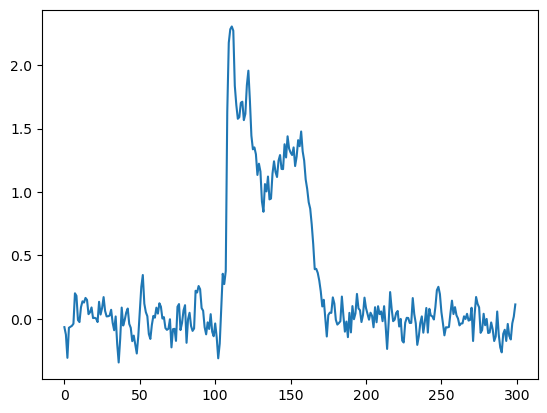

In [27]:
plt.plot(np.mean(snips, axis=0))

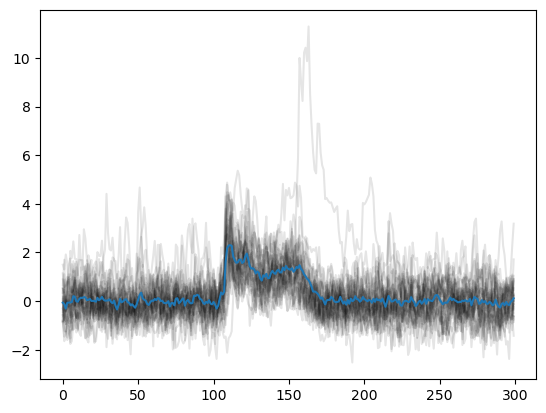

In [29]:
f, ax = plt.subplots()
for snip in snips:
    ax.plot(snip, color="black", alpha=0.1)

plt.plot(np.mean(snips, axis=0))
    

In [10]:
df

,Rat,Sex,Date,Condition,Epocs
0,SVG130,female,210727,FD,Sper
1,SVG130,female,210729,adlib,Sper
2,SVG132,female,210727,adlib,Sper
3,SVG132,female,210729,FD,Sper
4,SVG134,female,210727,FD,Sper
5,SVG134,female,210729,adlib,Sper
6,SVG135,male,210727,adlib,Sper
7,SVG135,male,210729,FD,Sper
8,SVG137,male,210727,FD,Sper
9,SVG137,male,210729,adlib,Sper


In [14]:
data = tdt.read_block(str(DATAFOLDER / "LickVK-210727" / "Svg130-210727-115203"))

# tdt.read_block("C:\\Users\\jmc010\\Github\\time-averaged-da\\data\\LickVK-210727\\LickVK-210727\\Svg130-210727-115203")

read from t=0s to t=1517.88s


In [17]:
data.epocs.Sper.onset

array([  46.90722816,   86.91679232,  131.92658944,  181.936128  ,
        231.9458304 ,  291.95534336,  351.96502016,  411.97436928,
        451.98409728,  501.99379968,  552.00350208,  607.01310976,
        647.02267392,  687.03240192,  732.04219904,  782.0517376 ,
        832.06127616,  887.07072   ,  932.08051712,  992.09019392,
       1032.09975808, 1092.10943488, 1152.11894784, 1197.12841728,
       1242.1382144 , 1297.14782208, 1337.15755008, 1382.16718336,
       1432.17688576, 1477.18651904])

In [19]:
data.streams

x05A	[struct]
x65A	[struct]
Fi1d	[struct]
Fi1r	[struct]

In [21]:
blue = data.streams.x65A.data
uv = data.streams.x05A.data
fs = data.streams.x65A.fs

processed_signal = tp.processdata(blue, uv, fs=fs)

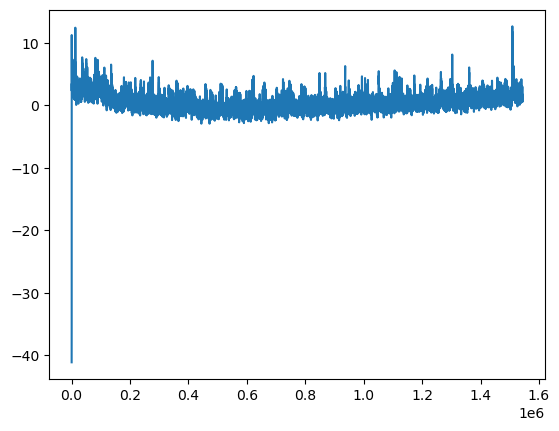

In [22]:
import matplotlib.pyplot as plt

plt.plot(processed_signal)